In [24]:
# import local libraries using host specific paths
import socket, sys
hostname = socket.gethostname().split('.')[0]
# set local path settings based on computer host
if hostname == 'PFC':
    pylibrary = '/Users/connylin/Dropbox/Code/proj'
elif hostname == 'Angular-Gyrus':
    pylibrary = '/Users/connylin/Code/proj'
else:
    assert False, 'host computer not regonized'
# load local libraries
if pylibrary not in sys.path:
    sys.path.insert(1, pylibrary)
# import brainstation_capstone
# import other standard paths and local variables
from brainstation_capstone.system import host_paths
localpaths = host_paths.get(hostname)

# import standard libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# get standard machine learning input data
from brainstation_capstone.etl.datatransform import Nutcracker
X_train, X_test, y_train, y_test = Nutcracker(localpaths['datapath']).mldata(feature_reduction='None')

getting host computer specific paths


In [25]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
# run a simple one
my_model = RandomForestClassifier(n_estimators=10, random_state=318)
my_model.fit(X_train, y_train)

print(f'train score: {my_model.score(X_train, y_train)}')
print(f'test score: {my_model.score(X_test, y_test)}')

train score: 0.9918475
test score: 0.881155


Random forest is a lot better! Just a bit over fitting with 10 estimators.

Run a range of it

In [ ]:
# run 52 estimators
estimator_number = list(range(1, 52))
train_scores = []
test_scores = []


for number in estimator_number:
    my_model = RandomForestClassifier(n_estimators=number, random_state=318)
    my_model.fit(X_train, y_train)

    train_scores.append(my_model.score(X_train, y_train))
    test_scores.append(my_model.score(X_test, y_test))
    
    print(f'finished {number} estimators', end='\r')

Ran 52 estimators and then stuck for a day without any movemnent.

In [10]:
len(test_scores)

52

In [16]:
estimator_number = np.arange(52)
len(estimator_number)

52

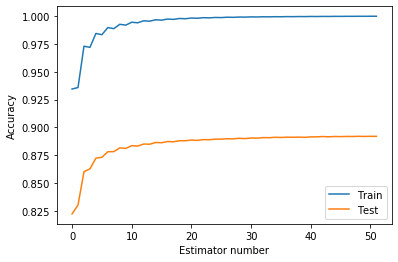

In [17]:
plt.figure()
plt.plot(estimator_number, train_scores, label="Train")
plt.plot(estimator_number, test_scores, label="Test")
plt.xlabel("Estimator number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

A lot of overfitting and maxed out at around 10 estimators. Need to be tuned.

Run rough tuning: 

In [28]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# get standard machine learning input data
from brainstation_capstone.etl.datatransform import Nutcracker
X_train, X_test, y_train, y_test = Nutcracker(localpaths['datapath']).mldata(feature_reduction='None')

# define models and parameters
model = RandomForestClassifier()
n_estimators = [3, 5, 10, 50, 100]
max_features = ['sqrt', 'log2']
n_splits = 5
cv = 5 # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=318)

# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, 
                           cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 